
# Analiza danych 2019/20 - predykcja zużycia energii
## Autor: Sławomir Mucha

# Wstęp

Celem projektu była analiza i zamodelowanie zbioru danych udostępnionego na platformie Kaggle, opisującego zużycie energii wewnątrz różnego typu budynków. 

Najważniejszymi zmiennymi w dostarczonym zbiorze danych były godzinne pomiary liczników prądu, wody zimnej, wody ciepłej i pary z okresu jednego roku. Zadaniem zaproponowanym przez organizatorów konkursu była predykcja wartości wspomnianych liczników na kolejne 2 lata wprzód.

Oprócz pomiarów liczników dane zawierały godzinne pomiary warunków atmosferycznych jak np. temperaturę powietrza, ciśnienie atmosferyczne oraz informacje dotyczące konkretnych budynków takie jak rozmiar powierzchni pomieszczeń, rok powstania czy też liczbę pięter.

Link do źródła danych: https://www.kaggle.com/c/ashrae-energy-prediction

# Wczytanie i wstępna obróbka danych

Dane dostarczono w pięciu plikach CSV:
- `train.csv`, `test.csv` - godzinowe pomiary liczników dla każdego budynku
- `building_metadata.csv` - opis budynków
- `weather_train.csv`, `weather_test.csv` - godzinowe dane atmosferyczne

Rozmiar plików osiągał powyżej 1GB, stąd przy wczytywaniu zastosowano bardziej oszczędne typy kolumn, np. `unit8`, `float16`, aby zredukować zużywaną pamięć gdziekolwiek to było możliwe. Do wczytania plików wykorzystano bibliotekę `pandas`.

In [1]:
from dataset import read_csv

TRAIN_DATA = './data/train.csv'
TEST_DATA = './data/test.csv'
BUILDING_METADATA = './data/building_metadata.csv'
WEATHER_TRAIN = './data/weather_train.csv'
WEATHER_TEST = './data/weather_test.csv'

train = read_csv(TRAIN_DATA)
test = read_csv(TEST_DATA)
building_metadata = read_csv(BUILDING_METADATA)
weather_train = read_csv(WEATHER_TRAIN)
weather_test = read_csv(WEATHER_TEST)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


Aby wykorzystać informacje o budynkach i pogodzie przy predykcji wskazań liczników pierwszym krokiem jest połączenie ze sobą zbiorów po wspólnych kluczach: `building_id` oraz (`site_id`, `timestamp`). Wynikiem takiej operacji jest zbiór z kompletem informacji dla danego pomiaru w pojedynczym wierszu.

In [2]:
import pandas

def merge_datasets(meter_readings, building_metadata, weather):
    intermediate = pandas.merge(meter_readings, building_metadata, on=['building_id'], how='left')
    return pandas.merge(intermediate, weather, on=['site_id', 'timestamp'], how='left')

train_merged = merge_datasets(train, building_metadata, weather_train)
test_merged = merge_datasets(test, building_metadata, weather_test)

train_merged.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [3]:
train_merged.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8088455.0,3506933.0,2.011944e+07,11390735.0,2.011596e+07,16467077.0,18984431.0,18767052.0,2.007242e+07
mean,7.992780e+02,6.624412e-01,1.988706e+03,7.992232e+00,1.077830e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.269133e+02,9.309921e-01,1.532159e+05,5.099060e+00,1.171424e+05,NaN,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1900.0,1.0,-2.890625e+01,0.0,-3.500000e+01,-1.0,968.0,0.0,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1951.0,1.0,8.601562e+00,0.0,0.000000e+00,0.0,1011.5,70.0,2.099609e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1969.0,3.0,1.670312e+01,0.0,8.898438e+00,0.0,1016.0,180.0,3.099609e+00
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,1993.0,6.0,2.409375e+01,4.0,1.609375e+01,0.0,1020.5,280.0,4.601562e+00
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2017.0,26.0,4.718750e+01,9.0,2.609375e+01,343.0,1046.0,360.0,1.900000e+01


Z powyższych statystyk można zauważyć, że dostarczone dane są bardzo zróżnicowane:
- wysokie odchylenie standardowe `meter_reading` (10^5) wskazuje na duże różnice w odczytach poszczególnych liczników ,
- odchylenie standardowe `square_feet` (10^5) mówi o analize budynków o bardzo zróżnicowanej powierzchni,
- budynki zostały wybudowane na przestrzeni 117 lat (od 1900 do 2017),
- wysokość budynków waha się od 1 do 26 pięter.

Niektóre kolumny pierwszych kilku wierszy zawierały wartości brakujące `NaN`. Ich proporcja w stosunku do całego zbioru ma znaczenie dla stosowanego modelu oraz potencjalnej strategii ich wypełniania. Poniżej sprawdzono proporcje dla zbioru treningowego oraz testowego.

In [4]:
def null_percentage(series):
    return series.isnull().sum() / len(series)

print("Train:")
print(null_percentage(train_merged))
print("Test:")
print(null_percentage(test_merged))

Train:
building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.599900
floor_count           0.826528
air_temperature       0.004781
cloud_coverage        0.436551
dew_temperature       0.004953
precip_depth_1_hr     0.185447
sea_level_pressure    0.060925
wind_direction        0.071678
wind_speed            0.007107
dtype: float64
Test:
row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.589916
floor_count           0.826050
air_temperature       0.005322
cloud_coverage        0.468664
dew_temperature       0.006255
precip_depth_1_hr     0.187099
sea_level_pressure    0.060359
wind_direction        0.071435
wind_speed 

Kolumny `year_built` i `floor_count` zawierają ponad 55% brakujących wartości - w pierwszym podejściu postanowiono je usunąć. Reszta brakujących wartości zostanie uzupełniona różnymi strategiami w dalszej części obróbki danych. 

In [5]:
train_merged = train_merged.drop(["year_built", "floor_count"], axis=1)
test_merged = test_merged.drop(["year_built", "floor_count"], axis=1)

W celu ułatwienia dalszej analizy kolumna `timestamp` została przekonwertowana na obiekt daty.

In [6]:
import pandas as pd

train_merged['timestamp'] = pd.to_datetime(train_merged['timestamp'])
test_merged['timestamp'] = pd.to_datetime(test_merged['timestamp'])

# Badania eksploracyjne

## Wizualizacja pomiarów

Na początku badań eksploracyjnych zwizualizowano szereg czasowy uśrednionich pomiarów liczników po dniu i godzinie, aby zaobserwować istnienie potencjalnych prawidłowości lub anomalii w dostarczonych danych.

In [7]:
from matplotlib import pyplot as plt

train = train_merged

fig, axes = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Średnia godzinna').set_ylabel('Odczyt liczników', fontsize=8);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Średnia dzienna').set_ylabel('Odczyt liczników', fontsize=8);
axes.set_title('Średni odczyt liczników po dniu i godzinie', fontsize=12);
axes.legend();
plt.show()

<Figure size 800x400 with 1 Axes>

Na powyższym wykresie charakterystyczny jest uskok w pomiarach pomiędzy czerwcem a lipcem, pomiary od lipca są zauważalnie niższe. Wykres wskazuje na potencjalną niespójność w danych.

Kolejne wykresy przedstawiają te sami wartości średnie pogrupowane po regionach w których znajdują się budynki (kolumna `site_id`). 

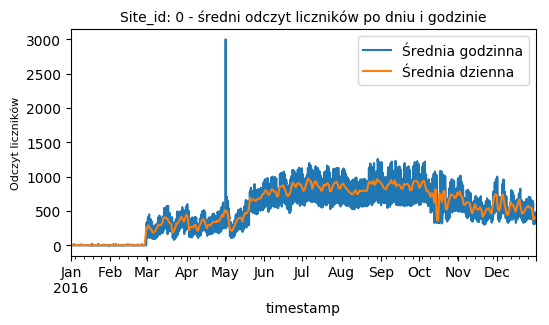

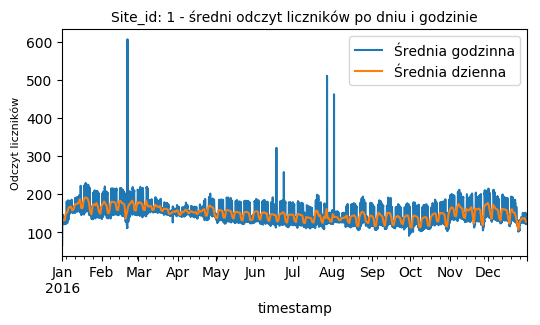

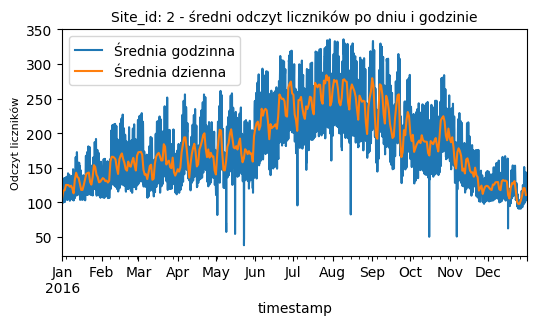

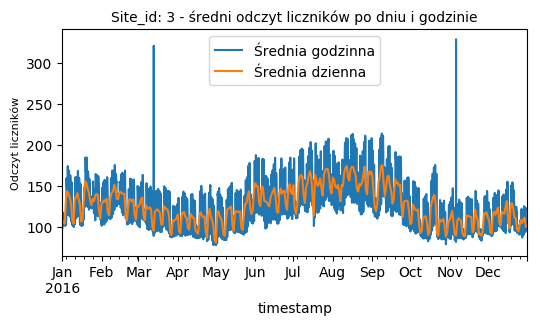

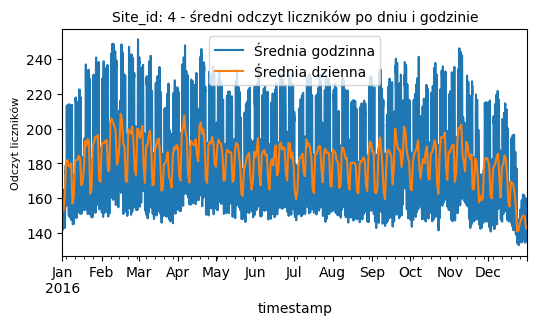

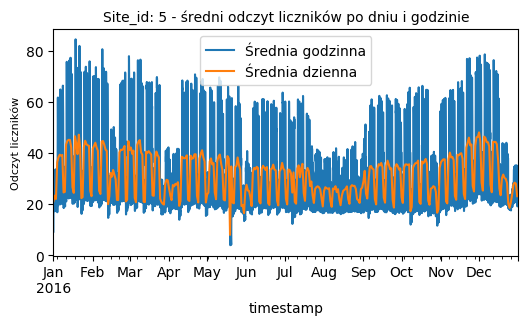

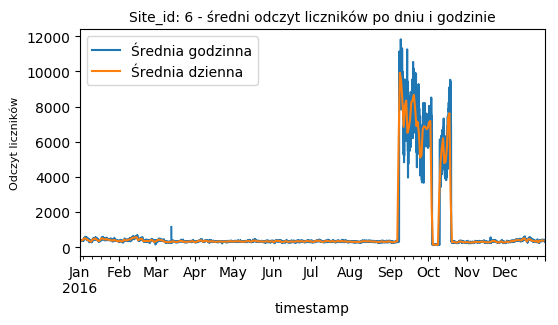

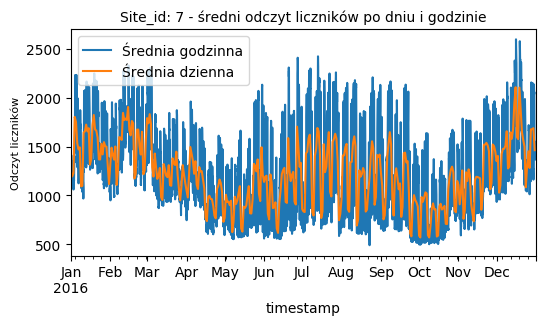

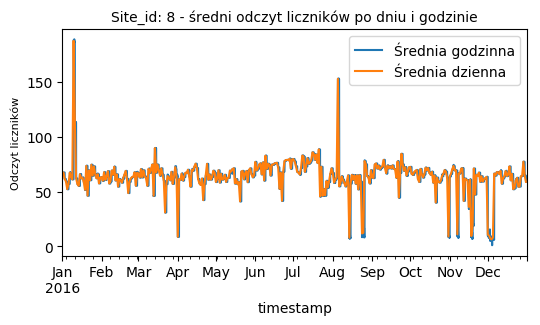

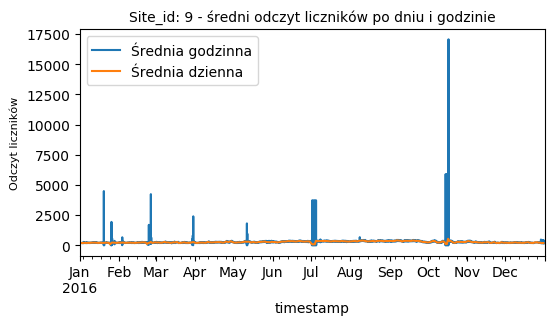

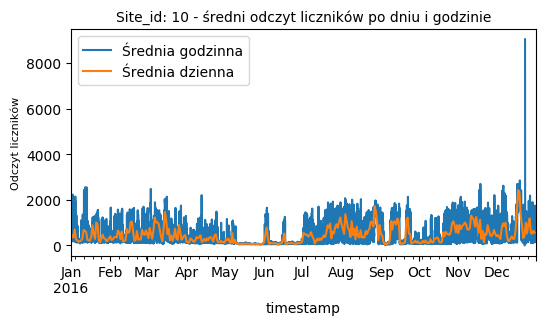

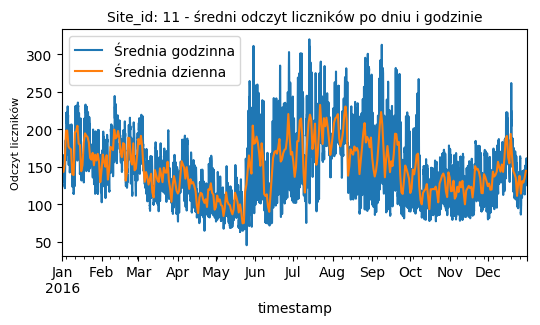

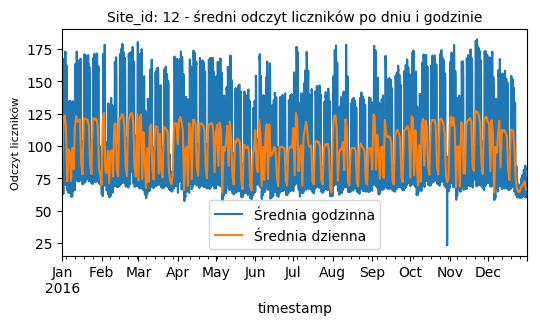

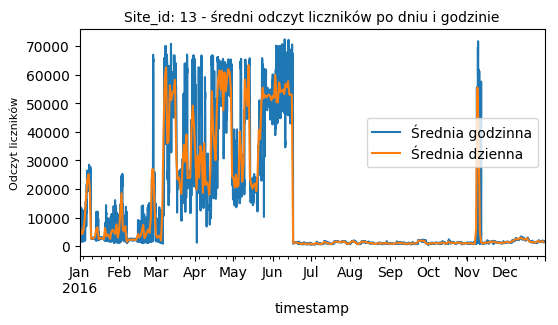

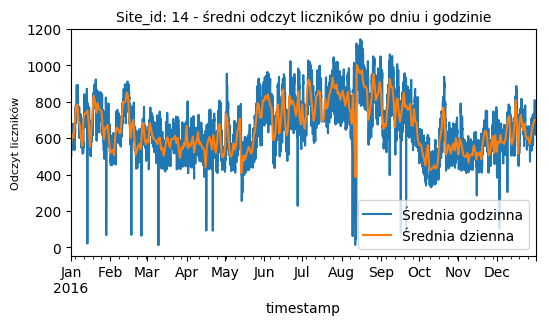

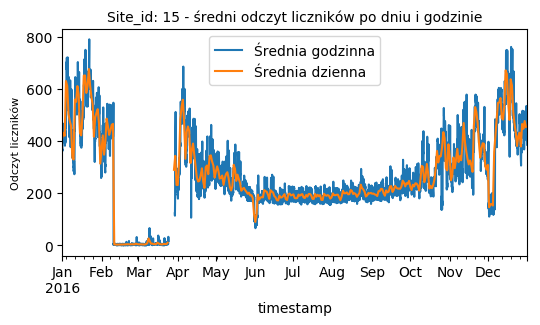

In [8]:
for site_id in range(train.site_id.nunique()):
    plottable = train[train.site_id == site_id]

    fig, axes = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
    plottable[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Średnia godzinna').set_ylabel('Odczyt liczników', fontsize=8);
    plottable[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Średnia dzienna').set_ylabel('Odczyt liczników', fontsize=8);
    axes.set_title(f'Site_id: {site_id} - średni odczyt liczników po dniu i godzinie', fontsize=10);
    axes.legend();
    plt.show()

Z powyższych diagramów wynika kilka obserwacji:
- pomiary dla `site_id` = 0 zaczynają się od marca,
- krzywa dla `site_id` = 13 przypomina krzywą w pierwszym wykresie uśrednionym po wszystkich regionach - występuje klif w okolicach czerwca i utrzymująca się niska wartość aż do grudnia,
- z wykresu dla `site_id` = 9 wynika, że ten region ma mało pomiarów innych niż zero,
- w regionie 15 wystąpił nieoczekiwany spadek w odczytach pomiędzy lutym a kwietniem

Powyższe obserwacje wskazują na fakt istnienia potencjalnych awarii i błędów w stacjach pomiarowych. Zaobserwowane anomalie nie powinny być brane pod uwagę przy modelowaniu przyszłych odczytów, ponieważ nie odzwierciedlają realnych wartości zużytej energii.

Dotychczasowe wykresy ukazują średnie wartości po wszystkich licznikach i budynkach w danym regionie na przestrzeni całego roku. Aby porównać powyższe wykresy z wartościami nieuśrednionymi, wybrano kilka konkretnych budynków (`building_id` = 56, 341, 1028, 1258) dla których narysowano pomiary każdego z liczników:

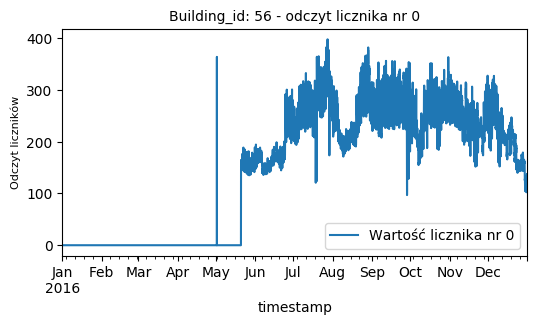

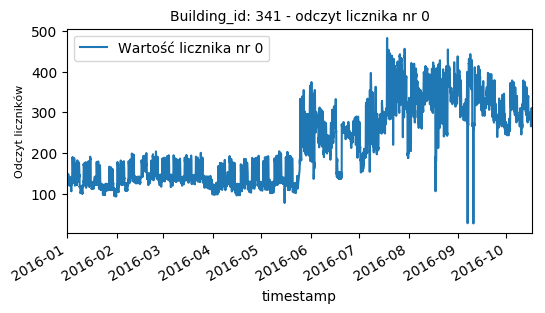

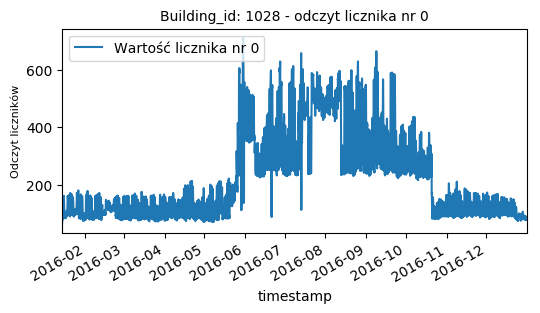

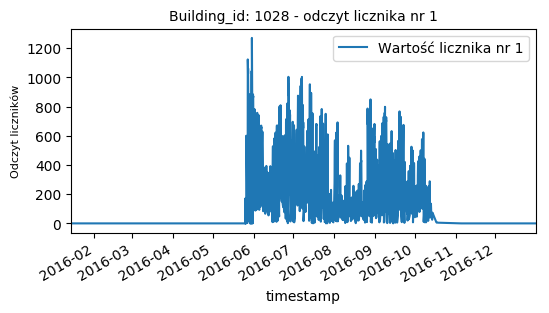

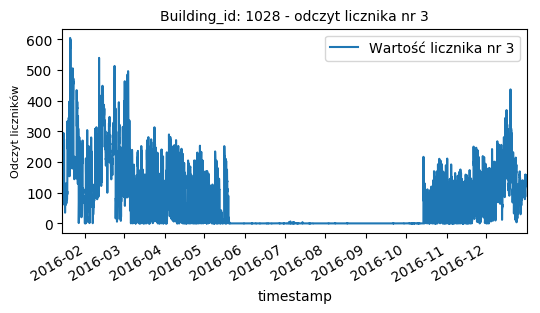

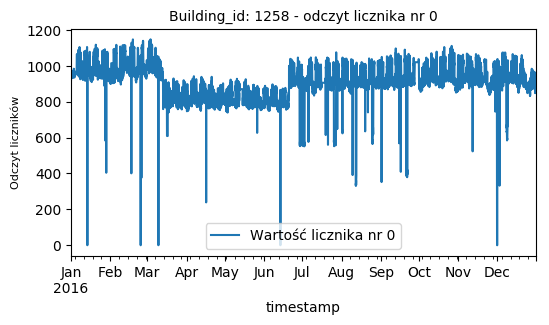

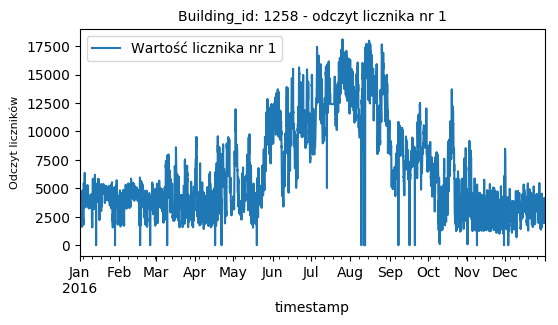

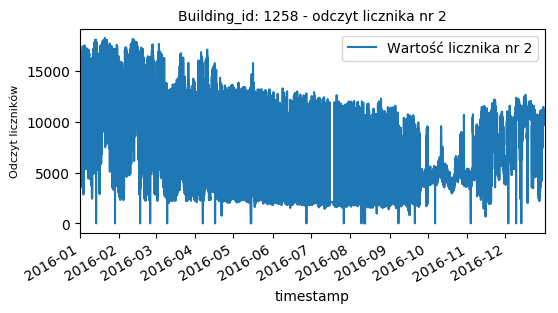

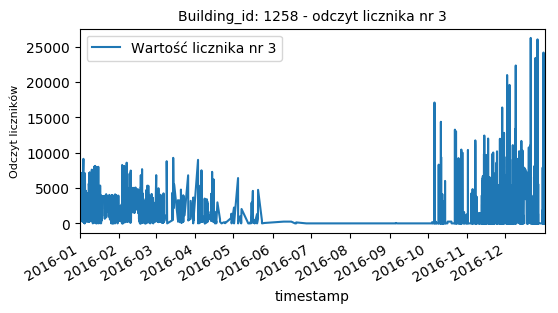

In [9]:
building_ids = (56, 341, 1028, 1258)

for building_id in building_ids:
    meter_ids = train[(train.building_id == building_id)].meter.unique()
    
    for meter_id in meter_ids:
        plottable = train[(train.building_id == building_id) & (train.meter == meter_id)]

        fig, axes = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
        plottable[['timestamp', 'meter_reading']].set_index('timestamp')['meter_reading'].plot(ax=axes, label=f'Wartość licznika nr {meter_id}').set_ylabel('Odczyt liczników', fontsize=8);
        axes.set_title(f'Building_id: {building_id} - odczyt licznika nr {meter_id}', fontsize=10);
        axes.legend();
        plt.show()

Na podstawie powyższych wykresów można przypuszczać, że rodzaj licznika oraz sam stan budynku mają decydujący wpływ na wartość zużycia energii. Wartym poruszenia jest fakt różnej skali odnotowanych pomiarów w różnych budynkach. Aby lepiej ocenić istotność czynników mających wpływ na pomiar, w kolejnych sekcjach wykorzystano modele uczenia maszynowego w celu ewaluacji istotności cech na podstawie dostarczonych danych.

# Przetwarzanie danych

W kolejnym kroku dane zostaną przygotowane do formatu odpowiedniego dla modeli uczenia maszynowego. Wykonany zostanie szereg czynności:
- sprowadzono etykiety przykładów do skali logarytmicznej - sugerowaną metryką w konkursie Kaggle było RMSLE, 
- zmienne kategoryczne (np. `primary_use`, `site_id`) zostaną stransformowane na tzw. one-hot encoding,
- zmienne numeryczne zostaną przeskalowane do zakresu [-1, 1],
- brakujące wartości zostaną zastąpione medianami odpowiednich kolumn,
- kolumna `meter` z wartościami 0, 1, 2, 3 zostanie przekształcona w cztery kolumny `meter_0`, `meter_1`, `meter_2`, `meter_3` - pozwoli to na zredukowanie liczby wierszy oraz ułatwi uczenie w ustawieniu multi-task.

In [10]:
from datetime import datetime
from typing import Iterable

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer as BaseColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

DATE_NUMERIC = ('week',)
BUILDING_NUMERIC = ('square_feet',)
BUILDING_CATEGORIC = ('primary_use', 'site_id')
WEATHER_NUMERIC = ('air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
                   'sea_level_pressure', 'wind_direction', 'wind_speed')

NUMERIC_FEATURES = DATE_NUMERIC + BUILDING_NUMERIC + WEATHER_NUMERIC
CATEGORICAL_FEATURES = BUILDING_CATEGORIC
TARGETS = ('meter_reading_0', 'meter_reading_1', 'meter_reading_2', 'meter_reading_3')
DATE_FEATURES = ('timestamp',)
READY_FEATURES = ('building_id',)


class ColumnTransformer(BaseColumnTransformer):
    """
    https://github.com/scikit-learn/scikit-learn/issues/12525#issuecomment-436217100
    """
    def get_feature_names(self):
        col_name = []
        # the last transformer is ColumnTransformer's 'remainder'
        for transformer_in_columns in self.transformers_[:-1]:
            raw_col_name = transformer_in_columns[2]
            if isinstance(transformer_in_columns[1], Pipeline):
                transformer = transformer_in_columns[1].steps[-1][1]
            else:
                transformer = transformer_in_columns[1]
            try:
                names = transformer.get_feature_names()
            except AttributeError:  # if no 'get_feature_names' function, use raw column name
                names = raw_col_name
            if isinstance(names, np.ndarray):  # eg.
                col_name += names.tolist()
            elif isinstance(names, list):
                col_name += names
            elif isinstance(names, str):
                col_name.append(names)
        return col_name


def to_datetime(string):
    return datetime.strptime(string, '%y-%m-%d %H:%M:%S')


def to_week(date_string):
    return int(to_datetime(date_string).strftime("%V"))


def preprocess(df):
    merge_columns = ['building_id', 'timestamp', 'site_id', 'primary_use', 'square_feet',
                     'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
                     'sea_level_pressure', 'wind_direction', 'wind_speed']

    df = df.copy()
    df['meter_reading'] = np.log1p(df['meter_reading'])  # transform to log scale

    df_meter_0 = get_meter_data(df, 0)
    df_meter_1 = get_meter_data(df, 1)
    df_meter_2 = get_meter_data(df, 2)
    df_meter_3 = get_meter_data(df, 3)

    df_merged_0 = df_meter_0.merge(df_meter_1, how='outer', on=merge_columns)
    df_merged_1 = df_merged_0.merge(df_meter_2, how='outer', on=merge_columns)
    df_merged = df_merged_1.merge(df_meter_3, how='outer', on=merge_columns)

    df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])
    df_merged['week'] = df_merged['timestamp'].dt.week
    df_merged = df_merged.drop(columns=['timestamp'], axis=1)
    
    x_transformer = create_data_transformer(NUMERIC_FEATURES, CATEGORICAL_FEATURES, READY_FEATURES)
    x_transformer.fit(df_merged)
    X = x_transformer.transform(df_merged)

    y_transformer = create_targets_transformer(TARGETS)
    y_transformer.fit(df_merged)
    y = y_transformer.transform(df_merged)

    return X, y, x_transformer, y_transformer


def get_meter_data(df, meter):
    df_meter = df[df.meter == meter]
    df_meter = df_meter.drop(['meter'], axis=1)
    return df_meter.rename(columns={'meter_reading': f'meter_reading_{meter}'})


def create_data_transformer(
        numeric_features: Iterable[str],
        categorical_features: Iterable[str],
        ready_features: Iterable[str]) -> ColumnTransformer:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler(feature_range=(-1, 1)))
    ])

    return ColumnTransformer(transformers=[
        ('num', numeric_transformer, list(numeric_features)),
        ('cat', categorical_transformer, list(categorical_features)),
        ('pass', 'passthrough', list(ready_features)),
    ])


def create_targets_transformer(targets) -> ColumnTransformer:
    return ColumnTransformer(transformers=[
        ('pass', 'passthrough', list(targets))
    ])

In [11]:
train_merged = train_merged.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-21")')

In [12]:
X, y, x_transformer, y_transformer = preprocess(train_merged)

In [13]:
X.shape, y.shape

((12087724, 42), (12087724, 4))

In [14]:
feature_names = x_transformer.get_feature_names()
label_names = y_transformer.get_feature_names()

print(feature_names)
print(label_names)

['week', 'square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'x0_Education', 'x0_Entertainment/public assembly', 'x0_Food sales and service', 'x0_Healthcare', 'x0_Lodging/residential', 'x0_Manufacturing/industrial', 'x0_Office', 'x0_Other', 'x0_Parking', 'x0_Public services', 'x0_Religious worship', 'x0_Retail', 'x0_Services', 'x0_Technology/science', 'x0_Utility', 'x0_Warehouse/storage', 'x1_0', 'x1_1', 'x1_2', 'x1_3', 'x1_4', 'x1_5', 'x1_6', 'x1_7', 'x1_8', 'x1_9', 'x1_10', 'x1_11', 'x1_12', 'x1_13', 'x1_14', 'x1_15', 'building_id']
['meter_reading_0', 'meter_reading_1', 'meter_reading_2', 'meter_reading_3']


In [15]:
X[200].toarray(), y[200]

(array([[ 1.00000000e+00, -9.75786454e-01,  2.25872690e-02,
          7.77777778e-01,  2.17774936e-01, -9.94186047e-01,
          3.58974359e-01,  9.44444444e-01, -5.68256579e-01,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  3.07000000e+02]]),
 array([2.7160184,       nan,       nan,       nan], dtype=float32))

# Uczenie maszynowe - modele bazowe

W tej sekcji dane zostaną zamodelowane przy pomocy:
- SVM,
- random forest,
- techniki gradient boostingu, modelu LightGBM (odpowiednik XGBoost).

Na początku dane zostaną podzielone na zbiór treningowy i walidacyjny w proporcji 9:1.

In [16]:
def split_data(X, y):
    train_split = int(X.shape[0] * 0.9)
    return X[:train_split], y[:train_split], X[train_split:], y[train_split:]


X_train, y_train, X_valid, y_valid = split_data(X, y)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((10878951, 42), (10878951, 4), (1208773, 42), (1208773, 4))

Zbiór trenujący jest duży (12 mln przykładów uczących), w związku z czym faza eksperymentów, testowania różnych modeli i hiperparametrów trwałaby bardzo długo.

Na potrzeby tego projektu zdecydowano się zawęzić problem do ewaluacji licznika wody zimnej (licznik nr 1). W komórce poniżej obliczono, że 67% przykładów nie zawiera takiego pomiaru co pozwoli na znaczną redukcję rozpatrywanych przykładów.

In [17]:
np.isnan(y_train[:, 1]).sum() / len(y_train)

0.6640659563592115

In [18]:
mask = ~np.isnan(y_train[:, 1])
mask_valid = ~np.isnan(y_valid[:, 1])

X_train, y_train = X_train[mask], y_train[mask]
X_valid, y_valid = X_valid[mask_valid], y_valid[mask_valid]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3654610, 42), (3654610, 4), (527830, 42), (527830, 4))

Po zawężeniu zadania do licznika nr 1 w zbiorze trenującym znalazło się 3,6 mln przykładów.

Hiperparametry modeli zostaną wybrane z pomocą procedury przeszukiwania losowego (random search).

## SVM

In [19]:
from sklearn.utils import resample

n_samples = 50000

X_resampled, y_resampled = resample(X_train, y_train, n_samples=n_samples, replace=False)

In [20]:
X_resampled.shape, y_resampled.shape

((50000, 42), (50000, 4))

In [21]:
from sklearn.svm import SVR

model = SVR()
model.fit(X_resampled, y_resampled[:, 1])

/Users/smucha/miniconda3/envs/py3k/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
y_pred = model.predict(X_valid)
y_pred[y_pred < 0] = 0

In [23]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_pred, y_valid[:, 1]))

2.0657968219694625

## Random Forest

In [26]:
from sklearn.utils import resample

n_samples = 100000

X_resampled, y_resampled = resample(X_train, y_train, n_samples=n_samples, replace=False)

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestRegressor()

param_dist = {
    'n_estimators': [10, 20, 50, 100, 300],
    'max_depth': [None, 3, 5],
    'max_leaf_nodes': [None, 3, 8]
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20)
random_search.fit(X_resampled, y_resampled[:, 1])

/Users/smucha/miniconda3/envs/py3k/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
y_pred = model.predict(X_valid)
y_pred[y_pred < 0] = 0

In [29]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_pred, y_valid[:, 1]))

1.7854041610134368

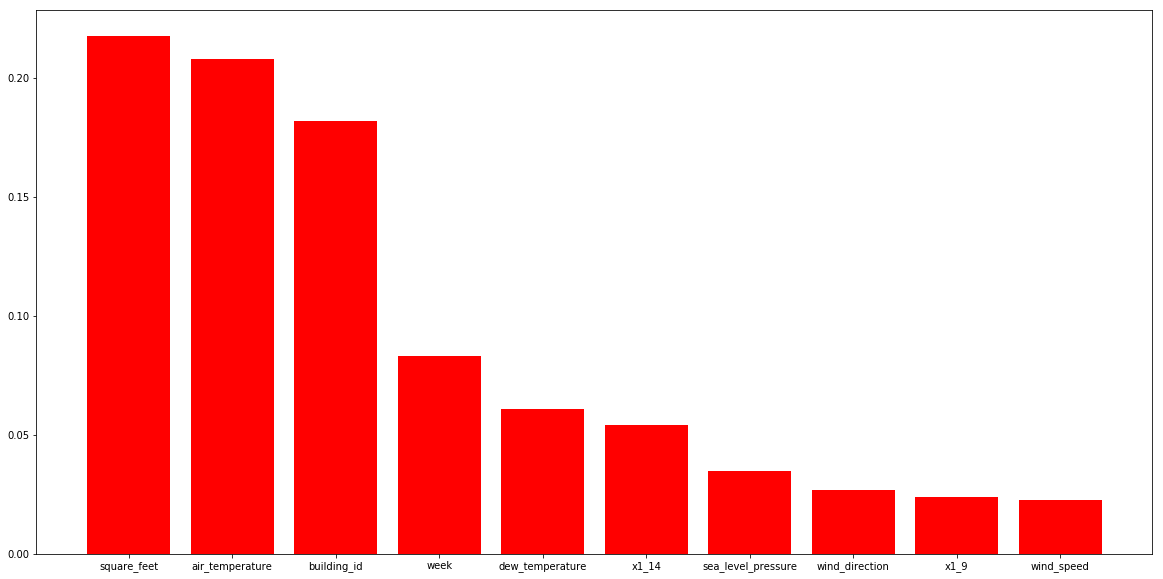

In [31]:
def plot_importance(labels, importances):
    best = np.argsort(importances)[::-1][:10]
    best_labels = [labels[i] for i in best]

    plt.figure(figsize=(20,10))
    plt.bar(np.arange(len(best_labels)), importances[best], align='center', color='red',)
    plt.xticks(np.arange(len(best_labels)), best_labels)    
    
plot_importance(feature_names, model.feature_importances_)

## LightGBM

In [44]:
import lightgbm as lgb

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

train_data = lgb.Dataset(X_train, label=y_train[:, 1])
valid_data = lgb.Dataset(X_valid, label=y_valid[:, 1])
gbm = lgb.train(params, train_data, valid_sets=[valid_data], verbose_eval=25, early_stopping_rounds=50)

/Users/smucha/miniconda3/envs/py3k/lib/python3.6/site-packages/lightgbm/basic.py:204: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.72256
[50]	valid_0's rmse: 1.63812
[75]	valid_0's rmse: 1.641
Early stopping, best iteration is:
[49]	valid_0's rmse: 1.63785


In [45]:
y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
y_pred[y_pred < 0] = 0

In [46]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_pred, y_valid[:, 1]))

1.6378517863690432

([<matplotlib.axis.XTick at 0x1225694e0>,
 <a list of 10 Text xticklabel objects>)

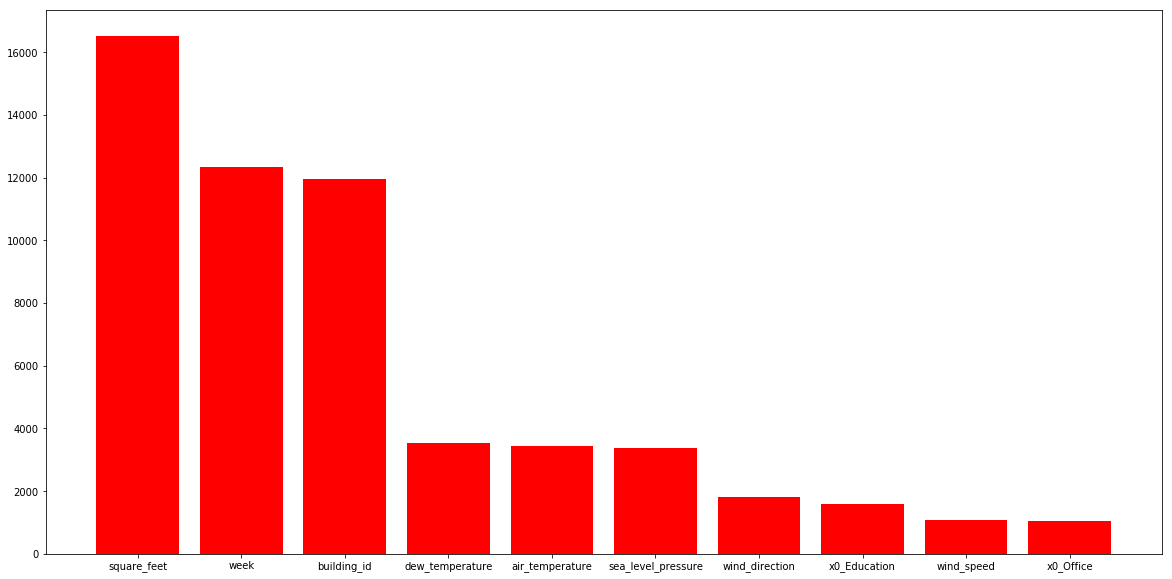

In [47]:
plot_importance(x_transformer.get_feature_names(), gbm.feature_importance())

# Uczenie głębokie

W projekcie rozważono również podejścia uczenia głębokiego i zastosowano model sieci neuronowej.

Jak wynikało z modeli klasycznych istotną cechą w decyzji o wyniku pomiaru był sam budynek (`building_id`) - stąd w poniższym modelu użyto warstwy embedding, aby każdy budynek opisać nisko wymiarowym wektorem (analogicznie jak słowa w modelach typu word2vec).

Dodatkowo sieć uczono w ustawieniu multi-task - pomimo ewaluacji jedynie na metryce licznika nr 1, funkcja kosztu liczona była na podstawie wszystkich dostępnych wartości mierników w danym rekordzie. Przypuszczano, że podejście multitask zadziała jak regularyzator, wymuszając bardziej ogólne cechy wewnątrz modelu.

In [113]:
import torch

class NeuralNetwork(torch.nn.Module):
    
    def __init__(self, input_size, buildings_number, output_size):
        super().__init__()

        self.embeddings = torch.nn.Embedding(buildings_number, 30)
        
        self.layer1 = torch.nn.Linear(input_size, 150)
        self.norm = torch.nn.BatchNorm1d(180)
        self.layer2 = torch.nn.Linear(180, 100)
        self.out = torch.nn.Linear(100, output_size)
        self.dropout = torch.nn.Dropout(0.3)
        
    def forward(self, X):
        features, building_ids = X[:, :-1], X[:, -1]
        
        embedded_buildings = self.embeddings(building_ids.long())
        x = self.layer1(features)
        x = torch.relu(self.norm(torch.cat((x, embedded_buildings), 1)))        
        x = torch.relu(self.dropout(self.layer2(x)))
        return self.out(x)
        

In [111]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 128

tensor_x = torch.Tensor(X_train.toarray())
tensor_y = torch.Tensor(y_train)

dataset = TensorDataset(tensor_x, tensor_y)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [114]:
EPOCHS = 5
BUILDINGS_NUMBER = 1750

model = NeuralNetwork(X_train.shape[1] - 1, BUILDINGS_NUMBER, y_train.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.train()
for epoch in range(EPOCHS):
    for i, (data, targets) in enumerate(loader):
        optimizer.zero_grad()

        out = model(data)
        
        not_present_targets = torch.isnan(targets)
        targets[not_present_targets] = 0
            
        out_ = out.clone()
        out_[not_present_targets] = 0

        loss = criterion(out_, targets)
        loss.backward()
        optimizer.step()
        
        if (i % 1000) == 0:
            print(f"epoch: {epoch} i: {i}  loss: {loss.item()}")

epoch: 0 i: 0  loss: 19.606069564819336
epoch: 0 i: 1000  loss: 2.432638168334961
epoch: 0 i: 2000  loss: 2.6120314598083496
epoch: 0 i: 3000  loss: 2.369584798812866
epoch: 0 i: 4000  loss: 1.8299520015716553
epoch: 0 i: 5000  loss: 1.7689998149871826
epoch: 0 i: 6000  loss: 1.4013099670410156
epoch: 0 i: 7000  loss: 1.6668195724487305
epoch: 0 i: 8000  loss: 1.5374245643615723
epoch: 0 i: 9000  loss: 1.659902572631836
epoch: 0 i: 10000  loss: 1.6103090047836304
epoch: 0 i: 11000  loss: 1.4291638135910034
epoch: 0 i: 12000  loss: 1.3033965826034546
epoch: 0 i: 13000  loss: 1.1386659145355225
epoch: 0 i: 14000  loss: 1.4578992128372192
epoch: 0 i: 15000  loss: 1.2548824548721313
epoch: 0 i: 16000  loss: 1.1246761083602905
epoch: 0 i: 17000  loss: 1.1710748672485352
epoch: 0 i: 18000  loss: 1.4358183145523071
epoch: 0 i: 19000  loss: 1.3173649311065674
epoch: 0 i: 20000  loss: 1.6632757186889648
epoch: 0 i: 21000  loss: 1.3628509044647217
epoch: 0 i: 22000  loss: 0.9272100925445557
epoc

In [115]:
tensor_valid = torch.Tensor(X_valid.toarray())
tensor_valid_y = torch.Tensor(y_valid)

In [116]:
model.eval()
pred = model(tensor_valid)

In [117]:
np.sqrt(mean_squared_error(pred[:, 1].detach().numpy(), y_valid[:, 1]))

1.8824098

In [118]:
pred[0], y_valid[0]

(tensor([3.2675, 0.5655, 4.7590, 4.4190], grad_fn=<SelectBackward>),
 array([3.12822  , 0.       , 5.3947997,       nan], dtype=float32))

Pomimo dużej liczby przykładów tak przygotowana sieć okazała się modelem gorszym od LightGBM (w ramach używanej metryki). 

# Podsumowanie

W projekcie wykonano analizę danych obejmującą wstępne przetwarzanie danych, analizę podstawowy statystyk, wykresy szeregów czasowych oraz wykrycie anomalii. Wykorzystano klasyczne modele uczenia maszynowego takie jak SVM, lasy losowe czy gradient boosting (LGMBoost), które pomogły ocenić istotność cech w zbiorze danych.

Wybór hiperparametrów zrealizowano przez random search.

Najbardziej istotnymi cechami w przypadku licznika nr 1 okazały się `square_feet`, `week`, `building_id` oraz `air_temperature`.

Ponadto zastosowano uczenie głębokie, które w tym wypadku (lub przez niedopasowaną architekturę) okazało mniej efektywnym podejściem.